In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import keras
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
import tensorflow_datasets as tfds
## Loading the data
mnist_bldr = tfds.builder('mnist')
#Have tensor flow prepare for me
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False)
mnist_train_orig = datasets['train']
mnist_test_orig = datasets['test']

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 60
NUM_EPOCHS = 1
mnist_train = mnist_train_orig.map(
lambda item: (tf.cast(item['image'], tf.float32)/255.0,
tf.cast(item['label'], tf.int32)))
mnist_test = mnist_test_orig.map(
lambda item: (tf.cast(item['image'], tf.float32)/255.0,
tf.cast(item['label'], tf.int32)))
tf.random.set_seed(1)
mnist_train = mnist_train.shuffle(buffer_size=BUFFER_SIZE,
reshuffle_each_iteration=False)
mnist_valid = mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(10000).batch(BATCH_SIZE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
#Load the model from keras
mnist = keras.datasets.mnist.load_data()
#It comes loaded seperated into testing and training(the first dinmension)
#The data also is seperated into X and y(pixel values and golden labels)(the second dimension)
#The X data is a 28x28 array that represents the image
X_training = mnist[0][0]
y_training = mnist[0][1]
X_testing = mnist[1][0]
y_testing = mnist[1][1]


input_shape = (28, 28, 1)

X_training=X_training.reshape(X_training.shape[0], X_training.shape[1], X_training.shape[2], 1)
X_training=X_training / 255.0

X_testing = X_testing.reshape(X_testing.shape[0], X_testing.shape[1], X_testing .shape[2], 1)
X_testing =X_testing/255.0

print(X_training.shape)
y_training = tf.one_hot(y_training.astype(np.int32), depth=10)
y_testing = tf.one_hot(y_testing.astype(np.int32), depth=10)


(60000, 28, 28, 1)


In [ ]:
#Convert the y data from 0-9 to an array where the Ith index of the array is a 1 to indicate the diget
#this is neccessary because it is illogical to say that if we predict 3 but it was really 4 then we are 'close'
#This is refered to as Hot-encoding

#Create an array 60,000x10 and fill it with zeros
y_training_array = np.zeros((60000,10))
#populate the 2d array with the golden data
for i in range(len(y_training)):
  #Convert 6 to [0,0,0,0,0,0,1,0,0,0] for example
  y_training_array[i][y_training[i]] = 1
y_training = y_training_array

#Create an array 10,000x10 and fill it with zeros
y_testing_array = np.zeros((10000,10))
#populate the 2d array with the golden data
for i in range(len(y_testing)):
  #Convert 6 to [0,0,0,0,0,0,1,0,0,0] for example
  y_testing_array[i][y_testing[i]] = 1
y_testing = y_testing_array

<ipython-input-131-643d410186aa>:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_training_array[i][y_training[i]] = 1


IndexError: ignored

In [ ]:
#There is a reason to view the data as it would appear in an actual image(aka a square)
#We want to maintain the shape unlike when it using a deep neural network because
#we will be applying filters and the location is therefor relevant.
#convert from 0-255 to from 0-1 where 0 is white and 1 is black and .5 is some gray
#There are 60,000 data points of 28x28
#Dividing by 255 makes the value a float between 0-1

X_training = X_training/255
X_testing = X_testing/255


In [ ]:
#We are using a sequential model
model = keras.Sequential()
model.add(keras.layers.Conv2D(
#there are 32 different 5x5 filters each one produces a different output, that we will learn from
filters=32, kernel_size=(5, 5),
#we use a stride of 1x1, and since we are using a 5x5 filter there will be a lot of
#overlap, this is expensive computationaly but it preserves more data.
strides=(1, 1),
#We are padding the input such that our output will also result in a 28x28 array
padding='same',
#Name this layer conv_1
name='conv_1',
#Use a relu activation which only gives positive weights for positive values, 0 otherwise
activation='relu'))

#Add a max pooling layer which is a filter that simply takes the largest value of a given
#Block and adds it to the output layer, this improves performance through pure magic
#In this filter the dimensions are 2x2, so it will take the greatest pixel value of the 4
#The strides default to the pool size so there is no overlapping and it reduces the size of the output by half
model.add(keras.layers.MaxPool2D(
pool_size=(2, 2), name='pool_1'))

#Create another convolutional layer but this time with 64 filters to learn from
model.add(keras.layers.Conv2D(
filters=64, kernel_size=(5, 5),
strides=(1, 1), padding='same',
name='conv_2', activation='relu'))

#Create another max pool filter layer
model.add(keras.layers.MaxPool2D(
pool_size=(2, 2), name='pool_2'))



In [ ]:
#add a flattening layer to get from our reduced image size to a network that could map to the hot encoding
#This leads to 3136 values that we will use as our input in an deep neural network to eventually get to the 1x10 output
model.add(keras.layers.Flatten())
#go from 3136 to 1024 in this layer
model.add(keras.layers.Dense(
units=1024, name='fc_1',
activation='relu'))
#drop out is here to add a level of randomness and prevent overfitting
model.add(keras.layers.Dropout(
rate=0.5))

#go from 1024 to 10 and use a softmax because we need the vector to be as a percentage confidence
model.add(keras.layers.Dense(
units=10, name='fc_2',
activation='softmax'))



In [ ]:
from tensorflow.keras import backend as K
#F1 score is 2 times the recall times the precision over precision plus recall
#for further discusion see part one
def custom_f1(y_true, y_pred):
    #Recall is the true positives over all the actuall positives
    def recall_m(y_true, y_pred):
        #True positives are the positives it correctly predicted
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        #epsilon is added here to assist in the division and ensure we do not divide by 0
        recall = TP / (Positives+K.epsilon())
        return recall

  #precision is the true positives over the predicted positives, see part one for further discusion
    def precision_m(y_true, y_pred):
        #True positives are the positives it correctly predicted
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return [precision, recall, 2*((precision*recall)/(precision+recall+K.epsilon()))]

In [ ]:
#Recall is the true positives over all the actuall positives
def recall_m(y_true, y_pred):
    #True positives are the positives it correctly predicted
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    #epsilon is added here to assist in the division and ensure we do not divide by 0
    recall = TP / (Positives+K.epsilon())
    return recall

#precision is the true positives over the predicted positives, see part one for further discusion
def precision_m(y_true, y_pred):
    #True positives are the positives it correctly predicted
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = TP / (Pred_Positives+K.epsilon())
    return precision

In [ ]:

tf.random.set_seed(1)
model.build(input_shape=(None, 28, 28, 1))
#model.build(input_shape=input_shape)

model.compile(
optimizer=keras.optimizers.Adam(),
loss=keras.losses.SparseCategoricalCrossentropy(),
metrics=[precision_m, recall_m,custom_f1, 'accuracy'])

#y_training = np.reshape(y_training, (1000,60,10,1))
#X_training = np.reshape(X_training,(1000, 60, 28,28, 1))
#history = model.fit(X_training, y_training,epochs=NUM_EPOCHS, batch_size = BATCH_SIZE, validation_split = 0.1)

history = model.fit(mnist_train,epochs=NUM_EPOCHS, batch_size = BATCH_SIZE, validation_data=mnist_valid, shuffle=True)

834/834 [==============================] - 186s 215ms/step - loss: 0.1410 - precision_m: 17386090.0000 - recall_m: 1.1606 - custom_f1: 5795363.0000 - accuracy: 0.9558 - val_loss: 0.0515 - val_precision_m: 0.9413 - val_recall_m: 1.0408 - val_custom_f1: 0.9901 - val_accuracy: 0.9835


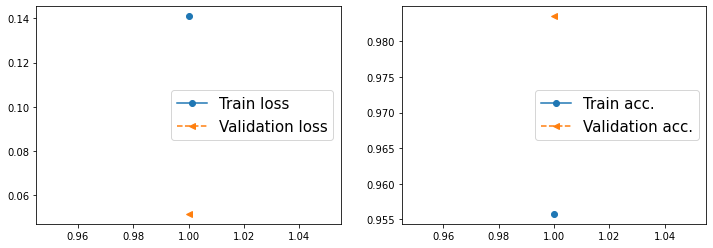

In [ ]:
import matplotlib.pyplot as plt
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<',
label='Validation acc.')
ax.legend(fontsize=15)
plt.show()

In [ ]:
test_results = model.evaluate(mnist_test.batch(20))
print('Test Acc.: {:.2f}\%'.format(test_results[1]*100))

500/500 [==============================] - 12s 23ms/step - loss: 0.0383 - precision_m: 0.9370 - recall_m: 1.0348 - custom_f1: 0.9846 - accuracy: 0.9877
Test Acc.: 93.70\%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

counter = 0

y = np.zeros(10000)
for item in mnist_test:
    image, label = item
    y[counter] = label.numpy()
    counter+=1

print(mnist_test.element_spec[1])
disp = ConfusionMatrixDisplay.from_estimator(
history,
mnist_test,
y,
display_labels=[0,1,2,3,4,5,6,7,8,9],
cmap=plt.cm.Blues,
normalize=("Normalized confusion matrix", "true"),
)
#disp.ax_.set_title(title)


print(disp.confusion_matrix)

plt.show()


TensorSpec(shape=(), dtype=tf.int32, name=None)


ValueError: ignored

In [ ]:


from sklearn.metrics import confusion_matrix
y_pred = history.predict(mnist_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)


fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
      ax.text(x=j, y=i,
      s=confmat[i, j],
      va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


AttributeError: ignored